In [1]:
# Load the essential libraries
import math

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.model_selection import cross_validate, KFold
from sklearn.datasets import load_svmlight_file

In [2]:
def load_dataset():
    # Load the training and testing data from the given files.
    # 124 features = 123 given features from the dataset + 1 bias
    x_train, y_train = load_svmlight_file("Dataset/a9a", n_features=124)
    x_test, y_test = load_svmlight_file("Dataset/a9a.t", n_features=124)

    # Change the data type to np.ndarray and add the bias term as the 124th feature
    x_train, x_test = x_train.toarray(), x_test.toarray()
    x_train[:,123], x_test[:,123] = 1, 1
    
    # Make the output binary
    y_train = [0 if sample == -1 else 1 for sample in y_train]
    y_test = [0 if sample == -1 else 1 for sample in y_test]
    
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_dataset()
    

In [3]:
mse_dict = {}
acc_train = {}
acc_test = {}
loss_train = {}
loss_test = {}

In [4]:
def sigmoid(val):
    return 1 / (1+np.exp(-val))


def update_weights(x, w, y, _lambda=0):
    mu = sigmoid(x @ w)
    R = np.diag(np.multiply(mu, 1-mu))
    # Hessian matrix
    H = - (np.transpose(x)@R@x) - (_lambda*np.identity(124))
    # Gradient loss term
    G = np.transpose(x)@(y-mu) - _lambda * w
    # Weight update
    w_new = w - np.linalg.pinv(H) @ G

    return w_new


def calc_accuracy(x, w, y, _lambda, mode):
    p = sigmoid(x@w)
    p = [0 if px <= 0.5 else 1 for px in p]

    num_correct = 0
    for i in range(len(p)):
        if (p[i] == y[i]):
            num_correct += 1

    acc = num_correct * 100 / len(p)

    print("Accuracy:", acc)

    if (mode == "train"):
        if (_lambda in acc_train.keys()):
            acc_train[_lambda].append(acc)
        else:
            acc_train[_lambda] = [acc]
    else:
        if (_lambda in acc_test.keys()):
            acc_test[_lambda].append(acc)
        else:
            acc_test[_lambda] = [acc]

    calc_loss(p, y, _lambda, mode)


def calc_loss(p, y, _lambda, mode):
    loss = metrics.log_loss(y, p)

    print("Loss:", loss)

    if (mode == "train"):
        if (_lambda in loss_train.keys()):
            loss_train[_lambda].append(loss)
        else:
            loss_train[_lambda] = [loss]
    else:
        if (_lambda in loss_test.keys()):
            loss_test[_lambda].append(loss)
        else:
            loss_test[_lambda] = [loss]


def calc_MSE(x, w, y):
    p = sigmoid(x@w)
    p = [0 if px <= 0.5 else 1 for px in p]
    y = np.array(y)

    mse = (np.square(y - p)).mean(axis=0)
    print("MSE ", mse)
    return mse



def train_model(x_train, w, y_train, _lambda, epoch=0):
    print("Training Epoch ==> %d" % epoch)

    if (epoch != 0):
        w = update_weights(x_train, w, y_train, _lambda)

    calc_accuracy(x_train, w, y_train, _lambda, "train")

    return w


def test_model(x_test, w, y_test, _lambda, epoch=0):
    print("Testing Epoch ==> %d" % epoch)
    calc_accuracy(x_test, w, y_test, _lambda, "")


def find_min_MSE(mse_dict):
    minimum = 1
    idx = 0
    for key, value in mse_dict.items():
        if (value < minimum):
            minimum = value
            idx = key

    return idx


def find_best_lambda(x_train, y_train):
    kf = KFold(n_splits=10)
    epochs = 10
    lambdas = [0.01, 0.1, 1, 2, 5, 10, 20, 50, 100]
    folds_used = 0

    for _lambda in lambdas:
        mse_average = 0
        for train_idx, test_idx in kf.split(x_train):
            folds_used += 1
            print("Using fold %d" % (folds_used))
            x_train_cv, y_train_cv = x_train[train_idx], np.array(y_train)[
                train_idx]
            x_test_cv, y_test_cv = x_train[test_idx], np.array(y_train)[
                test_idx]

            w = np.zeros((1, 124), dtype='float64')[0]
            w = train_model(x_train_cv, w, y_train_cv, _lambda, 0)
            mse_sum = calc_MSE(x_test_cv, w, y_test_cv)

            for epoch in range(1, epochs):
                # Train the model based on the train data
                w = train_model(x_train, w, y_train, _lambda, epoch)
                # Test the model
                mse_sum += calc_MSE(x_test_cv, w, y_test_cv)

            mse_average = mse_average + (mse_sum/epochs)

        mse_dict[_lambda] = mse_average / 10

    return find_min_MSE(mse_dict)

In [5]:
 x_train, y_train, x_test, y_test = load_dataset()
epochs = 10

_lambda = find_best_lambda(x_train, y_train)
lambdas = [0].append(_lambda)

for _lambda in lambdas:
    w = np.zeros((1, 124), dtype='float64')[0]
    w = train_model(x_train, w, y_train, _lambda, 0)
    test_model(x_test, w, y_test, _lambda, 0)

    for epoch in range(1, epochs):
        # Train the model based on the train data
        w = train_model(x_train, w, y_train, _lambda, epoch)
        # Test the model
        test_model(x_test, w, y_test, _lambda, epoch)

Using fold 1
Training Epoch ==> 0
Accuracy: 76.0066885066885
Loss: 8.286996206409261
MSE  0.2486951182069389
Training Epoch ==> 1
Accuracy: 84.52750222659009
Loss: 5.3440474336473125
MSE  0.16211237334970832
Training Epoch ==> 2
Accuracy: 84.81926230766868
Loss: 5.243281811116908
MSE  0.15597175314706785
Training Epoch ==> 3
Accuracy: 84.9451798163447
Loss: 5.199793801816271
MSE  0.1525944120356156
Training Epoch ==> 4
Accuracy: 84.93289518135192
Loss: 5.204037894045055
MSE  0.15382253607614368
Training Epoch ==> 5
Accuracy: 84.91139707011456
Loss: 5.21146342241115
MSE  0.15290144304574763
Training Epoch ==> 6
Accuracy: 84.91446822886275
Loss: 5.210402681758378
MSE  0.15290144304574763
Training Epoch ==> 7
Accuracy: 84.91446822886275
Loss: 5.210402681758378
MSE  0.15290144304574763
Training Epoch ==> 8


KeyboardInterrupt: 

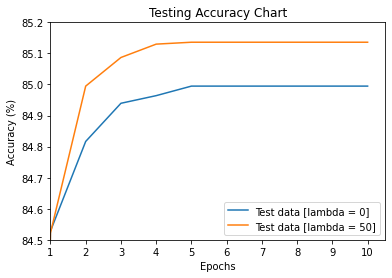

In [103]:
acc_test_0 = acc_test[0]
acc_test_50 = acc_test[50]

fig, ax = plt.subplots()
ax.plot(acc_test_0, label='Test data [lambda = 0]')
ax.plot(acc_test_50, label='Test data [lambda = 50]')
ax.set_title("Testing Accuracy Chart")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy (%)")
plt.xlim(left=1)
plt.ylim(84.5,85.2)
ax.set_xticks(list(range(1, 11)))
ax.legend()
plt.show()

fig = ax.get_figure()
fig.savefig("Figures/Acc_test", dpi=300)


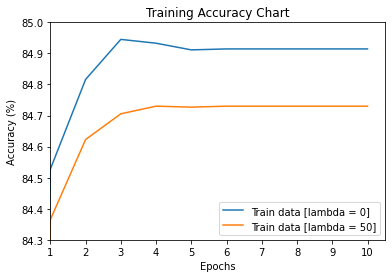

In [104]:
acc_train_0  = acc_train[0]
acc_train_50 = acc_train[50]

fig, ax = plt.subplots()
ax.plot(acc_train_0, label='Train data [lambda = 0]')
ax.plot(acc_train_50, label='Train data [lambda = 50]')
ax.set_title("Training Accuracy Chart")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy (%)")
plt.xlim(left=1)
plt.ylim(84.3,85)
ax.set_xticks(list(range(1, 11)))
ax.legend()
plt.show()

fig = ax.get_figure()
fig.savefig("Figures/Acc_train", dpi=300)

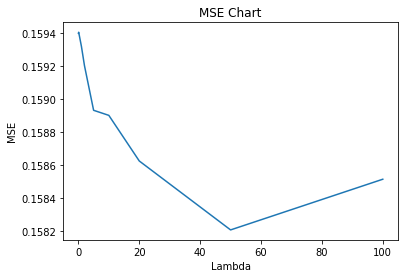

In [70]:
fig, ax = plt.subplots()
ax.plot(mse_dict.keys(), mse_dict.values())
ax.set_title("MSE Chart")
ax.set_xlabel("Lambda")
ax.set_ylabel("MSE")
plt.show()

fig = ax.get_figure()
fig.savefig("MSE", dpi=300)

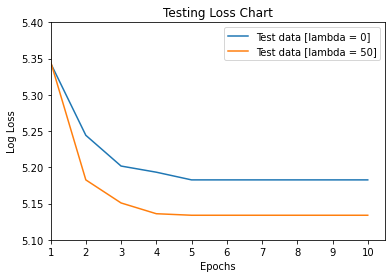

In [124]:
loss_test_0 = loss_test[0]
loss_test_50 = loss_test[50]

fig, ax = plt.subplots()
ax.plot(loss_test_0, label='Test data [lambda = 0]')
ax.plot(loss_test_50, label='Test data [lambda = 50]')
ax.set_title("Testing Loss Chart")
ax.set_xlabel("Epochs")
ax.set_ylabel("Log Loss")
plt.xlim(left=1)
plt.ylim(5.1, 5.4)
ax.set_xticks(list(range(1, 11)))
ax.legend()
plt.show()

fig = ax.get_figure()
fig.savefig("Figures/Loss_test", dpi=300)

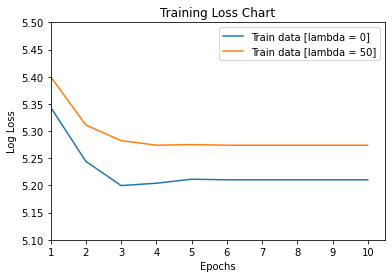

In [125]:
loss_train_0  = loss_train[0]
loss_train_50 = loss_train[50]

fig, ax = plt.subplots()
ax.plot(loss_train_0, label='Train data [lambda = 0]')
ax.plot(loss_train_50, label='Train data [lambda = 50]')
ax.set_title("Training Loss Chart")
ax.set_xlabel("Epochs")
ax.set_ylabel("Log Loss")
plt.xlim(left=1)
plt.ylim(5.1, 5.5)
ax.set_xticks(list(range(1, 11)))
ax.legend()
plt.show()

fig = ax.get_figure()
fig.savefig("Figures/Loss_train", dpi=300)